# End-to-end Multil-class Dog Breed Classification

## 1. Problem
Identifying the breed of a dog given an image of a dog.

## 2. Data

Dataset from Kaggle: https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

It's a file with prediction probabilities for each dog breed for each test image.

## 4. Features

Data info:
* Images (unstructured data).
* There are 120 breeds of dogs.
* There are around 10,000 images in the training set (images with labels).
* There are around 10,000 images in the test set (images without labels).

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
#!unzip "drive/MyDrive/ML/DogBreed/dog-breed-identification.zip" -d "drive/MyDrive/ML/DogBreed/"

### Workspace Setup

In [65]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Checking for gpU availability
print("GPU", "available :)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.15.0
TF Hub version: 0.16.1
GPU available :)


## Transform our data into tensors (np arrays)

In [66]:
import pandas as pd

labels_csv = pd.read_csv("drive/MyDrive/ML/DogBreed/labels.csv")
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [67]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [68]:
labels_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [69]:
labels_csv.isna().sum()

id       0
breed    0
dtype: int64

### How many images are there for each breed?

* Google recomends at least 10 for each class, the recommended is 100.

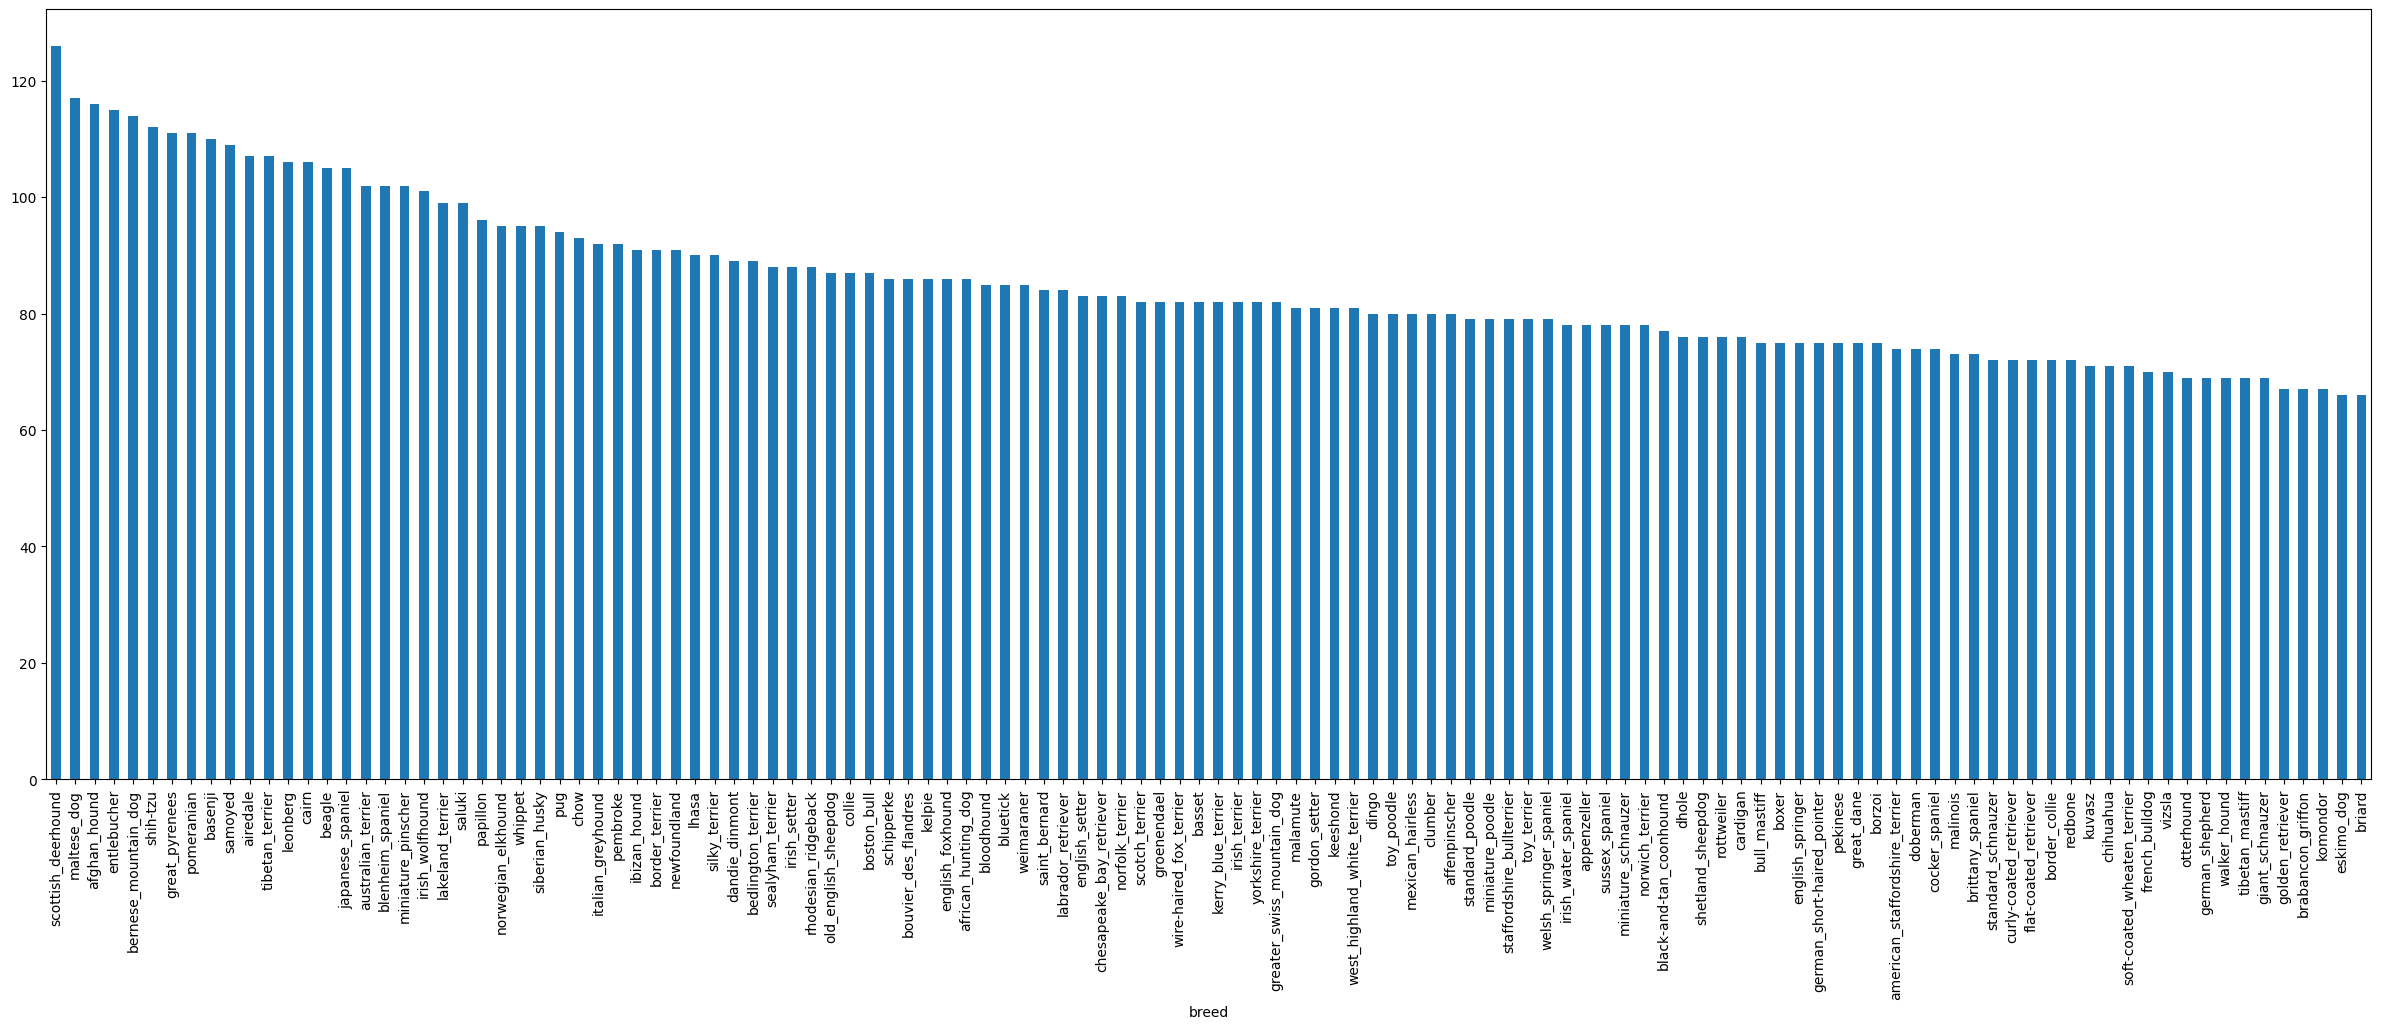

In [70]:
labels_csv["breed"].value_counts().plot.bar(figsize=(30, 10));

In [71]:
labels_csv["breed"].value_counts().median()

82.0

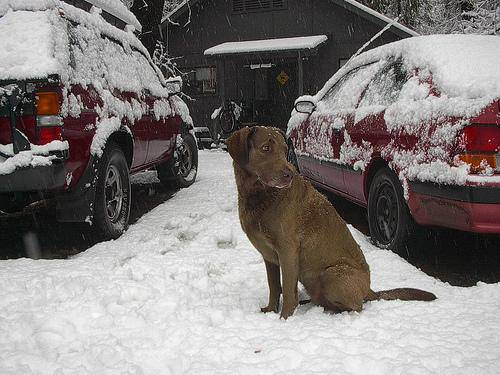

In [72]:
# Let's view an image
from IPython.display import Image

Image("drive/MyDrive/ML/DogBreed/train/fff43b07992508bc822f33d8ffd902ae.jpg")

### Getting images and their labels

In [73]:
filenames = ["drive/MyDrive/ML/DogBreed/train/" + fname + ".jpg" for fname in labels_csv["id"]]

filenames[:10]

['drive/MyDrive/ML/DogBreed/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/ML/DogBreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/ML/DogBreed/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/ML/DogBreed/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/ML/DogBreed/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/ML/DogBreed/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/ML/DogBreed/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/ML/DogBreed/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/ML/DogBreed/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/ML/DogBreed/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [74]:
# Checking if the number of filenames matches the number of actual image files
import os

if len(os.listdir("drive/MyDrive/ML/DogBreed/train/")) == len(filenames):
  print("Match")
else:
  print("Don't match")

Match


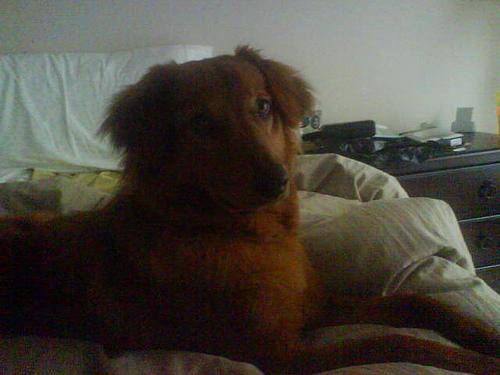

In [75]:
Image(filenames[1000])

In [76]:
import numpy as np

labels = np.array(labels_csv["breed"]).astype(str)

In [77]:
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype='<U30')

In [78]:
unique_breeds = np.unique(labels)
len(unique_breeds)

120

### Turning to numerical representation

In [79]:
labels[0] == unique_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [80]:
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:10]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [81]:
# Example: Turning boolean array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])[0][0]) # Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be a 1 where the sample label occurs

boston_bull
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

In [82]:
# Setup X and y
X = filenames
y = boolean_labels

Breaking up data for experimentation

In [83]:
# Hyperparameters are in capital
NUM_IMAGES =  1000 #@param {type:"slider", min:1000, max:10000}

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

In [85]:
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### Preprocessing images (turning images into Tensors)

#### Image format
Color Image (RGB):

Dimensions: (height, width, channels) \
Example shape: (512, 512, 3) where 3 represents the three color channels (Red, Green, Blue)

Step by step:
1. Take an image filepath as input.
2. Use `TensorFlow` to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpg) into Tensors.
4. Normalize our image (convert color channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224).
6. Return the modified `image`.

array([[[108,  46,   0],
        [152,  92,  42],
        [180, 120,  70],
        ...,
        [176, 144,  69],
        [189, 157,  82],
        [214, 182, 107]],

       [[151,  93,  47],
        [179, 121,  75],
        [167, 111,  64],
        ...,
        [167, 136,  56],
        [172, 139,  60],
        [188, 157,  77]],

       [[151,  98,  56],
        [188, 137,  94],
        [162, 113,  70],
        ...,
        [200, 168,  81],
        [196, 162,  75],
        [200, 168,  81]],

       ...,

       [[189, 122,  69],
        [186, 119,  66],
        [183, 116,  63],
        ...,
        [213, 160, 106],
        [212, 159, 107],
        [209, 156, 102]],

       [[186, 119,  66],
        [184, 117,  64],
        [183, 116,  63],
        ...,
        [197, 145,  88],
        [199, 146,  92],
        [199, 147,  90]],

       [[182, 115,  62],
        [181, 114,  61],
        [183, 116,  63],
        ...,
        [184, 132,  74],
        [190, 138,  81],
        [192, 140,  82]]], dtype=uint8)
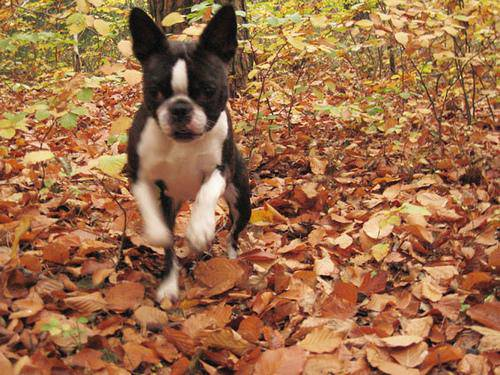

In [86]:
from matplotlib.pyplot import imread

image = imread(filenames[0])
image

In [87]:
# Img into a tensor
tf.constant(image)

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[108,  46,   0],
        [152,  92,  42],
        [180, 120,  70],
        ...,
        [176, 144,  69],
        [189, 157,  82],
        [214, 182, 107]],

       [[151,  93,  47],
        [179, 121,  75],
        [167, 111,  64],
        ...,
        [167, 136,  56],
        [172, 139,  60],
        [188, 157,  77]],

       [[151,  98,  56],
        [188, 137,  94],
        [162, 113,  70],
        ...,
        [200, 168,  81],
        [196, 162,  75],
        [200, 168,  81]],

       ...,

       [[189, 122,  69],
        [186, 119,  66],
        [183, 116,  63],
        ...,
        [213, 160, 106],
        [212, 159, 107],
        [209, 156, 102]],

       [[186, 119,  66],
        [184, 117,  64],
        [183, 116,  63],
        ...,
        [197, 145,  88],
        [199, 146,  92],
        [199, 147,  90]],

       [[182, 115,  62],
        [181, 114,  61],
        [183, 116,  63],
        ...,
        [184, 132,  7

## Reshape img to the correct format to pass to the model

In [88]:
IMG_SIZE = 224

def process_image(image_path):
  # Read img
  image = tf.io.read_file(image_path)

  # Turn it into Tensor with 3 color channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Convert to img format
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [89]:
tensor = tf.io.read_file(filenames[23])
tensor.dtype

tf.string

In [90]:
tensor = tf.image.decode_jpeg(tensor, channels=3)

In [91]:
tf.image.convert_image_dtype(tensor, tf.float32)[:2]

<tf.Tensor: shape=(2, 291, 3), dtype=float32, numpy=
array([[[0.83921576, 0.9176471 , 0.91372555],
        [0.9450981 , 1.        , 1.        ],
        [0.64705884, 0.7058824 , 0.7176471 ],
        ...,
        [0.9921569 , 1.        , 0.9607844 ],
        [0.9843138 , 1.        , 0.9686275 ],
        [0.9843138 , 1.        , 0.9686275 ]],

       [[0.909804  , 0.9725491 , 0.9686275 ],
        [0.89019614, 0.95294124, 0.9490197 ],
        [0.3803922 , 0.43529415, 0.43921572],
        ...,
        [0.98823535, 0.9960785 , 0.97647065],
        [0.9803922 , 1.        , 0.97647065],
        [0.98823535, 0.9960785 , 0.9843138 ]]], dtype=float32)>

## Turning our data into batches

Why turn our data into batches?
If you're trying to process 10,000+ images in one go... They all might not fit into memory.

So that's why we do 32 images (batch size) at a time.

In order to use TensorFlow, the data needs to be in the following tuple format:
`(image, label)`

In [92]:
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [93]:
(process_image(X[24]), tf.constant(y))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.        , 0.02205882, 0.0004902 ],
         [0.00205707, 0.03686975, 0.00378151],
         [0.00747549, 0.04903712, 0.01661415],
         ...,
         [0.02267136, 0.07724071, 0.03515386],
         [0.04925642, 0.09582529, 0.05936681],
         [0.00441176, 0.02794118, 0.00588235]],
 
        [[0.        , 0.03921569, 0.00539216],
         [0.02015932, 0.06678046, 0.03295694],
         [0.04519433, 0.08964461, 0.05761555],
         ...,
         [0.08460237, 0.14753135, 0.1039739 ],
         [0.10557685, 0.16096902, 0.12028274],
         [0.02205882, 0.07745098, 0.03676471]],
 
        [[0.        , 0.03921569, 0.00784314],
         [0.02633053, 0.06883754, 0.03746499],
         [0.05254727, 0.09568454, 0.06431198],
         ...,
         [0.08066337, 0.1504638 , 0.10379888],
         [0.08968931, 0.15733637, 0.11174814],
         [0.        , 0.06764706, 0.02205883]],
 
        ...,
 
        [[0.00490196, 0.02009804

In [94]:
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels)
  """
  if test_data:
    print("TEST")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    return data.map(process_image).batch(BATCH_SIZE)

  elif valid_data:
    print("VALID")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    return data.map(get_image_label).batch(BATCH_SIZE)

  else:
    print("TRAINING")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

    # Shuffling pathnames and labels before mapping since it's easies than shuffling images
    data = data.shuffle(buffer_size=len(X))

    return data.map(get_image_label).batch(BATCH_SIZE)

In [95]:
# Creating training and validation batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

TRAINING
VALID


In [96]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

In [103]:
import matplotlib.pyplot as plt

def show_25_images(images, labels):
  plt.figure(figsize=(10, 10))

  for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

In [104]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_labels = train_labels.astype(str)
train_images[:2], train_labels[:2]

(array([[[[0.1330032 , 0.05492197, 0.08260179],
          [0.12281288, 0.04473164, 0.07286915],
          [0.10271296, 0.02463172, 0.05307436],
          ...,
          [0.5843801 , 0.2659036 , 0.23074335],
          [0.42622918, 0.17718755, 0.12505569],
          [0.24508326, 0.04996776, 0.01638262]],
 
         [[0.4086272 , 0.375257  , 0.39908588],
          [0.36725003, 0.33319327, 0.35938936],
          [0.29389817, 0.25938374, 0.28715795],
          ...,
          [0.44133395, 0.20268634, 0.185602  ],
          [0.36695412, 0.16867074, 0.15405174],
          [0.2550185 , 0.08574145, 0.07356845]],
 
         [[0.56696117, 0.58506346, 0.6011555 ],
          [0.5850034 , 0.6031056 , 0.6203419 ],
          [0.5720782 , 0.59018046, 0.6081795 ],
          ...,
          [0.13036056, 0.00890197, 0.00958708],
          [0.24564041, 0.12379038, 0.15058532],
          [0.19309051, 0.06804112, 0.1088118 ]],
 
         ...,
 
         [[0.45460117, 0.4624443 , 0.1369541 ],
          [0.52042

In [105]:
len(train_images), len(train_labels)

(32, 32)

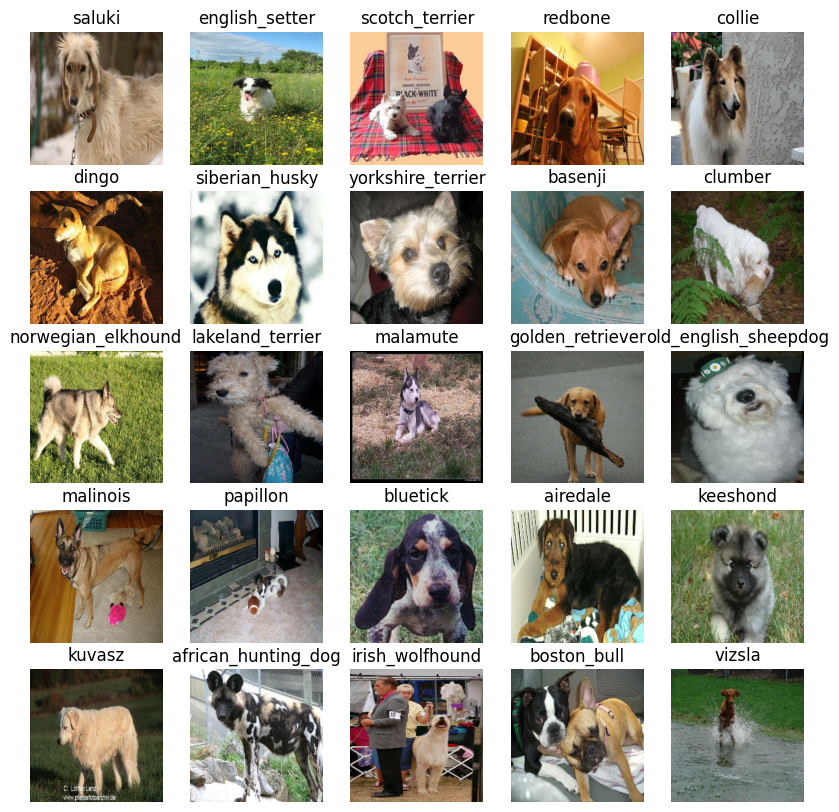

In [109]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [108]:
unique_breeds[y[0].argmax()]

'boston_bull'

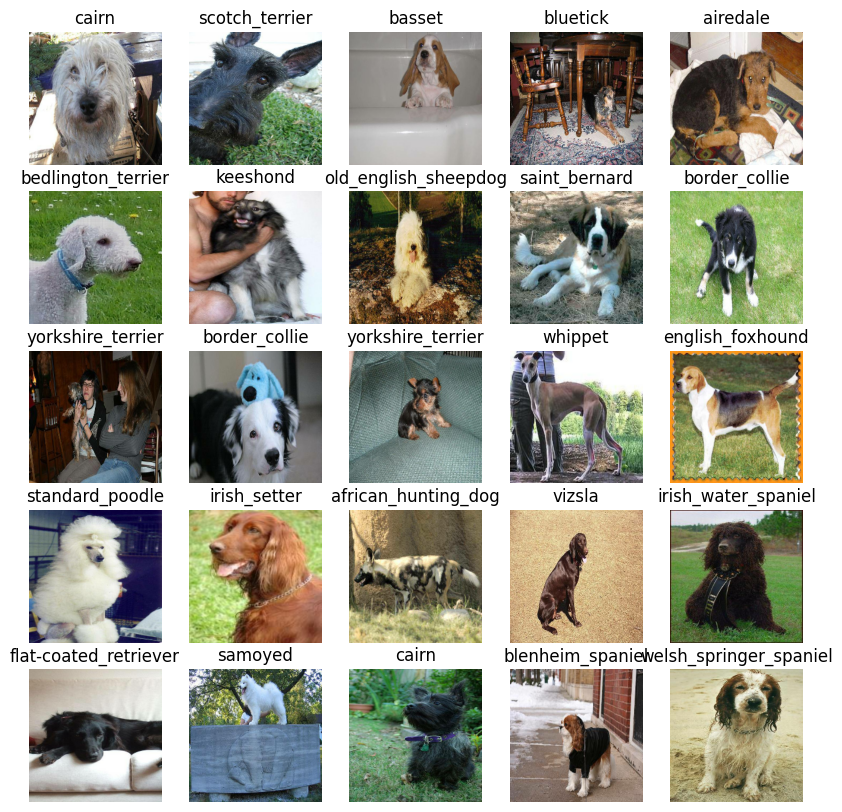

In [111]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)